In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import keras
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import numpy as np
import pandas as pd
from collections import defaultdict
import re


import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from tensorflow.keras.layers import *
from keras.models import Model

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9910338048219205868
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13789880675356409962
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16087287453232534738
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11146783616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5986245475989596057
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [ ]:
data_train = pd.read_csv('/content/gdrive/MyDrive/new/TanKianLong_1181300023/dataset/D2.csv')

In [ ]:
# Shuffle the data
from sklearn.utils import shuffle
data_train = shuffle(data_train)
data_train = data_train.reset_index(drop=True)

In [ ]:
data_train.head()

,title,text,subject,date,label
0,Clinton slams student loan servicer Navient as...,"HENNIKER, N.H. (Reuters) - U.S. Democratic pre...",politicsNews,"February 6, 2016",0
1,KELLYANNE CONWAY: “Where The Hell Were Those D...,Kellyanne Conway appeared on the Sean Hannity ...,politics,"May 6, 2017",1
2,Iraqi PM Abadi demands Kurds cancel secession ...,BAGHDAD (Reuters) - Iraq s prime minister dema...,worldnews,"October 26, 2017",0
3,BREAKING: Acting FBI Director McCabe Contradi...,Acting FBI Director Andrew McCabe testified to...,News,"May 11, 2017",1
4,OUTRAGE! OBAMA’S FEDERAL Wildlife Officers (?)...,US Border Agents and local law enforcement gav...,left-news,"Jul 9, 2016",1


In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [ ]:
# Convert to lowercase

data_train['text'] = data_train['text'].apply(lambda x: x.lower())
data_train.head()

,title,text,subject,date,label
0,Clinton slams student loan servicer Navient as...,"henniker, n.h. (reuters) - u.s. democratic pre...",politicsNews,"February 6, 2016",0
1,KELLYANNE CONWAY: “Where The Hell Were Those D...,kellyanne conway appeared on the sean hannity ...,politics,"May 6, 2017",1
2,Iraqi PM Abadi demands Kurds cancel secession ...,baghdad (reuters) - iraq s prime minister dema...,worldnews,"October 26, 2017",0
3,BREAKING: Acting FBI Director McCabe Contradi...,acting fbi director andrew mccabe testified to...,News,"May 11, 2017",1
4,OUTRAGE! OBAMA’S FEDERAL Wildlife Officers (?)...,us border agents and local law enforcement gav...,left-news,"Jul 9, 2016",1


In [ ]:
# Check
data_train.head()

,title,text,subject,date,label
0,Clinton slams student loan servicer Navient as...,"henniker, n.h. (reuters) - u.s. democratic pre...",politicsNews,"February 6, 2016",0
1,KELLYANNE CONWAY: “Where The Hell Were Those D...,kellyanne conway appeared on the sean hannity ...,politics,"May 6, 2017",1
2,Iraqi PM Abadi demands Kurds cancel secession ...,baghdad (reuters) - iraq s prime minister dema...,worldnews,"October 26, 2017",0
3,BREAKING: Acting FBI Director McCabe Contradi...,acting fbi director andrew mccabe testified to...,News,"May 11, 2017",1
4,OUTRAGE! OBAMA’S FEDERAL Wildlife Officers (?)...,us border agents and local law enforcement gav...,left-news,"Jul 9, 2016",1


In [ ]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data_train['text'] = data_train['text'].apply(punctuation_removal)

In [ ]:
# Check
data_train.head()

,title,text,subject,date,label
0,Clinton slams student loan servicer Navient as...,henniker nh reuters us democratic presidentia...,politicsNews,"February 6, 2016",0
1,KELLYANNE CONWAY: “Where The Hell Were Those D...,kellyanne conway appeared on the sean hannity ...,politics,"May 6, 2017",1
2,Iraqi PM Abadi demands Kurds cancel secession ...,baghdad reuters iraq s prime minister demande...,worldnews,"October 26, 2017",0
3,BREAKING: Acting FBI Director McCabe Contradi...,acting fbi director andrew mccabe testified to...,News,"May 11, 2017",1
4,OUTRAGE! OBAMA’S FEDERAL Wildlife Officers (?)...,us border agents and local law enforcement gav...,left-news,"Jul 9, 2016",1


In [ ]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english','arabic')
stop.extend(["said", "reuters", "CNN", "would", "image", "via"])

data_train['text'] = data_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data_train.head()

,title,text,subject,date,label
0,Clinton slams student loan servicer Navient as...,henniker nh us democratic presidential candida...,politicsNews,"February 6, 2016",0
1,KELLYANNE CONWAY: “Where The Hell Were Those D...,kellyanne conway appeared sean hannity show gu...,politics,"May 6, 2017",1
2,Iraqi PM Abadi demands Kurds cancel secession ...,baghdad iraq prime minister demanded thursday ...,worldnews,"October 26, 2017",0
3,BREAKING: Acting FBI Director McCabe Contradi...,acting fbi director andrew mccabe testified to...,News,"May 11, 2017",1
4,OUTRAGE! OBAMA’S FEDERAL Wildlife Officers (?)...,us border agents local law enforcement gave jo...,left-news,"Jul 9, 2016",1


In [ ]:
def clean_str(string):
    """
    Cleaning of dataset
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [ ]:
#print('What the raw input data looks like:')
#print(data_train[0:5])
texts = []
labels = []

for i in range(data_train.text.shape[0]):
    text2 = data_train.text[i]
    text =  str(text2)
    texts.append(text)
    labels.append(data_train.label[i])
    
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 245228 unique tokens.


In [ ]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (44898, 1000)
Shape of label tensor: (44898, 2)


In [ ]:
# Train test validation Split
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( x_test, y_test, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 35918 4490 4490
real & fake news in train,valt,test:
[17150. 18768.]
[2123. 2367.]
[2144. 2346.]


In [ ]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Dense, Embedding, LSTM, GRU

%matplotlib inline

In [ ]:
GLOVE_DIR = "data" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, '/content/gdrive/My Drive/FYP/report/ALL/LSTM/glove.6B.100d.txt'), encoding="utf8") #The file that you had downloaded and moved from local session to drive.

In [ ]:
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)


Total 400000 word vectors in Glove.


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

Bidirectional LSTM

In [ ]:
embedding_vecor_length = 32
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix], input_length = MAX_SEQUENCE_LENGTH, trainable=False, name = 'embeddings'))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(100)))  # one LSTM Layer with 100 neurons
model.add(Dense(2,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (Embedding)       (None, 1000, 100)         24522900  
_________________________________________________________________
dropout (Dropout)            (None, 1000, 100)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 2)                 402       
Total params: 24,684,102
Trainable params: 161,202
Non-trainable params: 24,522,900
_________________________________________________________________
None


In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
history = model.fit(x_train, 
                     y_train, 
                     epochs=10, 
                     batch_size=128, 
                     validation_data=(x_val, y_val))

Epoch 1/10
281/281 [==============================] - 103s 368ms/step - loss: 0.3021 - accuracy: 0.8725 - val_loss: 0.2334 - val_accuracy: 0.9053
Epoch 2/10
281/281 [==============================] - 103s 365ms/step - loss: 0.2597 - accuracy: 0.8916 - val_loss: 0.2671 - val_accuracy: 0.8900
Epoch 3/10
281/281 [==============================] - 103s 366ms/step - loss: 0.2107 - accuracy: 0.9176 - val_loss: 0.4268 - val_accuracy: 0.8094
Epoch 4/10
281/281 [==============================] - 103s 365ms/step - loss: 0.1688 - accuracy: 0.9350 - val_loss: 0.1295 - val_accuracy: 0.9499
Epoch 5/10
281/281 [==============================] - 103s 365ms/step - loss: 0.1641 - accuracy: 0.9367 - val_loss: 0.1405 - val_accuracy: 0.9514
Epoch 6/10
281/281 [==============================] - 103s 365ms/step - loss: 0.1369 - accuracy: 0.9488 - val_loss: 0.1191 - val_accuracy: 0.9548
Epoch 7/10
281/281 [==============================] - 103s 365ms/step - loss: 0.1193 - accuracy: 0.9541 - val_loss: 0.0997 -

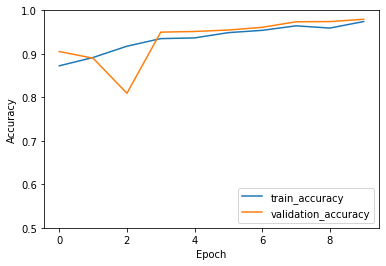

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

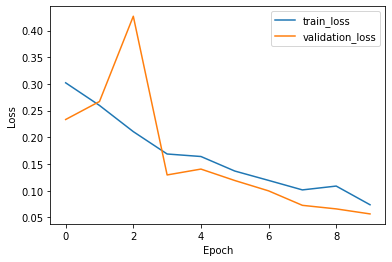

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
y_pred = model.predict_classes(x_val)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
test_preds = model.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Correct predictions: 4404.0
Total number of test examples: 4490
Accuracy of model1:  0.9808463251670378


In [ ]:
y_test[1]

array([0., 1.], dtype=float32)

In [ ]:
import numpy as np
rounded_labels=np.argmax(y_test, axis=1)

In [ ]:
rounded_labels

array([0, 1, 0, ..., 1, 0, 1])

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict_classes(x_test)

In [ ]:
print(classification_report(rounded_labels, y_pred, target_names=['negative','positive']))

              precision    recall  f1-score   support

    negative       0.97      0.99      0.98      2144
    positive       0.99      0.97      0.98      2346

    accuracy                           0.98      4490
   macro avg       0.98      0.98      0.98      4490
weighted avg       0.98      0.98      0.98      4490

